### Laboratorio 4 - Deep Learning
Stefano Aragoni, Carol Arevalo, Luis Santos


Utilice el dataset compartido en el espacio para construir la mejor red neuronal posible según las técnicas de
optimización vistas en clase.

Objetivo. Maximizar accuracy del pronóstico de la columna Y. default payment next month

-------

#### Importar librerias

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dense, BatchNormalization, GaussianDropout
from keras import regularizers
from keras.layers import Dense, Dropout, LeakyReLU, PReLU, ELU
from keras.layers import Activation

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from keras.optimizers import Adam

--------

#### Importar Datos y Limpieza de Datos


A continuación se importan los datos y se realiza una limpieza de los mismos.

In [125]:
excel_file_path = "creditcard.xlsx"
df = pd.read_excel(excel_file_path, header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Posteriormente se eliminan las columnas irrelevantes para el análisis.

In [127]:
# eliminar columna ID
df = df.drop(['ID'], axis=1)

Como se puede observar, no hay datos faltantes, por lo que no es necesario realizar cambios en los datos.

<AxesSubplot: >

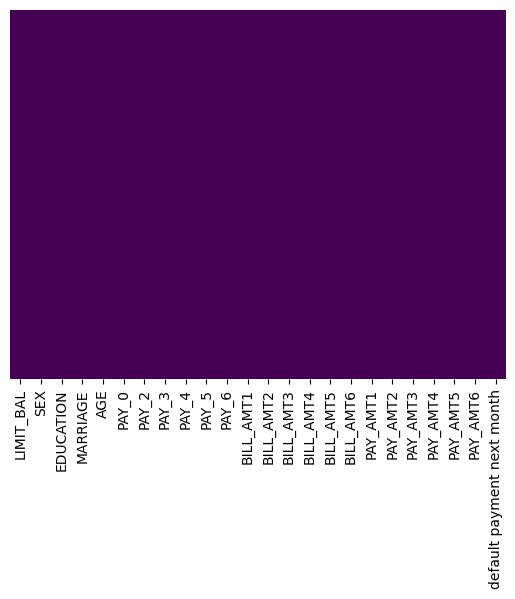

In [128]:
# Revisar datos faltantes
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Se optó por escalar los datos para que todos los datos estén en el mismo rango. Esto permite que sea más fácil el entrenamiento de la red neuronal.

In [129]:
# MinMax Scaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.010101,1.0,0.333333,0.333333,0.051724,0.4,0.4,0.1,0.1,0.0,...,0.160138,0.080648,0.260979,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000,1.0
1,0.111111,1.0,0.333333,0.666667,0.086207,0.1,0.4,0.2,0.2,0.2,...,0.163220,0.084074,0.263485,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783,1.0
2,0.080808,1.0,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0.0
3,0.040404,1.0,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0.0
4,0.040404,0.0,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0.0
5,0.040404,0.0,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,...,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0.0
6,0.494949,0.0,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,...,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0.0
7,0.090909,1.0,0.333333,0.666667,0.034483,0.2,0.1,0.1,0.2,0.2,...,0.160346,0.080490,0.261414,0.000435,0.000357,0.000000,0.000936,0.003955,0.002917,0.0
8,0.131313,1.0,0.500000,0.333333,0.120690,0.2,0.2,0.4,0.2,0.2,...,0.171640,0.092342,0.263837,0.003811,0.000000,0.000482,0.001610,0.002345,0.001892,0.0
9,0.010101,0.0,0.500000,0.666667,0.241379,0.0,0.0,0.0,0.0,0.1,...,0.160138,0.093545,0.271670,0.000000,0.000000,0.000000,0.020945,0.002631,0.000000,0.0


Luego, se realizó un análisis para determinar la media y desviación estándar de las variables. Como se puede observar, los datos no están normalizados. Se recomienda utilizar Batch Normalization para normalizar los datos en cada capa.

In [130]:
# mean and standard deviation for each column
df_scaled.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.159075,0.603733,0.308856,0.517289,0.249750,0.19833,0.186623,0.183380,0.177933,0.173380,...,0.200891,0.120620,0.290851,0.006483,0.003516,0.005832,0.007771,0.011252,0.009865,0.221200
std,0.131058,0.489129,0.131725,0.173990,0.158929,0.11238,0.119719,0.119687,0.116914,0.113319,...,0.060601,0.060284,0.045766,0.018961,0.013680,0.019650,0.025227,0.035820,0.033627,0.415062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040404,0.000000,0.166667,0.333333,0.120690,0.10000,0.100000,0.100000,0.100000,0.100000,...,0.162330,0.082396,0.261944,0.001145,0.000495,0.000435,0.000477,0.000592,0.000223,0.000000
50%,0.131313,1.000000,0.333333,0.666667,0.224138,0.20000,0.200000,0.200000,0.200000,0.200000,...,0.178084,0.098600,0.274097,0.002404,0.001193,0.002009,0.002415,0.003517,0.002837,0.000000
75%,0.232323,1.000000,0.333333,0.666667,0.344828,0.20000,0.200000,0.200000,0.200000,0.200000,...,0.211482,0.130415,0.298787,0.005731,0.002969,0.005028,0.006463,0.009452,0.007566,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Determinar cuales son las columnas que se van a utilizar para el entrenamiento de la red neuronal. 

Se usa la matriz de correlación para determinar cuales son las columnas que tienen mayor correlación con la columna Y.

In [77]:
# Calcula la matriz de correlación
corr_matrix = df_scaled.corr()

# Extrae la columna de correlaciones con la variable objetivo
correlation_with_target = corr_matrix['default payment next month']

# Ordena las correlaciones por valor absoluto en orden descendente
sorted_correlation = correlation_with_target.abs().sort_values(ascending=False)

# Imprime la lista ordenada de correlaciones
print(sorted_correlation)

default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
LIMIT_BAL                     0.153520
PAY_AMT1                      0.072929
PAY_AMT2                      0.058579
PAY_AMT4                      0.056827
PAY_AMT3                      0.056250
PAY_AMT5                      0.055124
PAY_AMT6                      0.053183
SEX                           0.039961
EDUCATION                     0.028006
MARRIAGE                      0.024339
BILL_AMT1                     0.019644
BILL_AMT2                     0.014193
BILL_AMT3                     0.014076
AGE                           0.013890
BILL_AMT4                     0.010156
BILL_AMT5                     0.006760
BILL_AMT6                     0.005372
Name: default payment next month, dtype: float64


Finalmente, se indica un threshold para determinar cuales son las columnas que se van a utilizar para el entrenamiento de la red neuronal.

In [88]:
threshold = 0.1
columns_to_keep = sorted_correlation[sorted_correlation >= threshold].index

df_filtered = df_scaled[columns_to_keep]

df_filtered.head()

,default payment next month,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL
0,1.0,0.4,0.4,0.1,0.1,0.0,0.0,0.010101
1,1.0,0.1,0.4,0.2,0.2,0.2,0.4,0.111111
2,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.080808
3,0.0,0.2,0.2,0.2,0.2,0.2,0.2,0.040404
4,0.0,0.1,0.2,0.1,0.2,0.2,0.2,0.040404


--------

#### Creación de Red Neuronal

Como primer paso, se separan los datos en datos de entrenamiento y datos de prueba.

In [98]:
# Separa la variable objetivo (default payment next month)
X = df_filtered.drop("default payment next month", axis=1)
y = df_filtered["default payment next month"]

# Divide los datos en entrenamiento (90%), validación (10%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Posteriormente, se creaó la Red Neuronal en una función para poder realizar pruebas con diferentes parámetros.

In [99]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_model(learning_rate=0.0001, dropout_rate=0.5, l2_lambda=0.01):
    model = Sequential()
    
    model.add(Dense(128, input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

Posteriormente, se declararon los parámetros que se van a utilizar para el entrenamiento de la red neuronal con GridSearchCV.

In [103]:
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.3, 0.4],
    'epochs': [15, 20],
    'batch_size': [8, 16]
}

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_95769/626817302.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


A través de GridSearchCV se determinó cual es la mejor combinación de parámetros para la red neuronal.

In [104]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, verbose=10)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.001
[CV 1/2; 1/16] END batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.001;, score=0.822 total time=  52.9s
[CV 2/2; 1/16] START batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.001
[CV 2/2; 1/16] END batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.001;, score=0.815 total time=  50.4s
[CV 1/2; 2/16] START batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.01
[CV 1/2; 2/16] END batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.01;, score=0.820 total time=  52.9s
[CV 2/2; 2/16] START batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.01
[CV 2/2; 2/16] END batch_size=8, dropout_rate=0.3, epochs=15, learning_rate=0.01;, score=0.814 total time=  50.6s
[CV 1/2; 3/16] START batch_size=8, dropout_rate=0.3, epochs=20, learning_rate=0.001
[CV 1/2; 3/16] END batch_size=8, dropout_rate=0.3, epochs=20, l

Finalmente, se determinó el accuracy de la red neuronal con los datos de validación.

In [111]:
# Val Accuracy
best_model = grid_result.best_estimator_.model

accuracy = best_model.evaluate(X_val, y_val, verbose=0)[1]
print("Validation Accuracy: {:.4f}".format(accuracy))

Validation Accuracy: 0.8202
